Preliminary Cosumnes Model Spin up
Michigan Bar to lower Rooney Ranch
Created on Thu Apr  2 17:59:11 2020

@author: Andrew

In [22]:
# For grid creation
import os
import sys
import numpy as np
# run installed version of flopy or add local path
try:
    from flopy.discretization.structuredgrid import StructuredGrid
    from flopy.utils.reference import SpatialReference
except:
    fpth = os.path.abspath(os.path.join('..', '..'))
    sys.path.append(fpth)
    from flopy.discretization.structuredgrid import StructuredGrid
    from flopy.utils.reference import SpatialReference

import matplotlib as mpl
import matplotlib.pyplot as plt
import flopy
import pyproj # for converting proj4string
import pandas as pd

print(sys.version)
print('numpy version: {}'.format(np.__version__))
print('matplotlib version: {}'.format(mpl.__version__))
print('flopy version: {}'.format(flopy.__version__))

3.6.10 |Anaconda, Inc.| (default, Mar 23 2020, 17:58:33) [MSC v.1916 64 bit (AMD64)]
numpy version: 1.18.1
matplotlib version: 3.2.1
flopy version: 3.3.0


In [71]:
nrow = 81
ncol = 52
delr = 200
delc = 200
nlay = 1

According to Flopy GitHub "Technically you need to create both a SpatialReference object and a ModelGrid object, but in practice the code looks very similar and can easily be implemented in one line."
WGS84 Zone 10N has EPSG: 32610  
Lower left corner of model is   
Zone 10 N  
Easting: 661211.18 m E  
Northing: 4249696.50 m N  
angle is approximate 53 degrees  

In [72]:
#lenuni = 1 is in ft, lenuni = 2 is in meters
mg = StructuredGrid(delc=delc*np.ones(ncol), delr=delr*np.ones(nrow), xoff=661211.18, yoff=4249696.50, angrot=53, 
                    epsg=32610, lenuni=2)

In [61]:
m = flopy.modflow.Modflow('toy_model', model_ws='data')

botm = np.zeros((nlay, nrow, ncol))
botm[0, :, :] = 1

dis = flopy.modflow.ModflowDis(nrow=nrow, ncol=ncol, 
                               nlay=1, delr=200, delc=200,
                               top=3, botm=botm, model=m)

In [63]:
grid = m.modelgrid
grid.set_coord_info(xoff=661211.18, yoff=4249696.50, proj4='EPSG:32610', angrot=53)
chk = dis.check()
chk.summary_array


DIS PACKAGE DATA VALIDATION:
  No errors or warnings encountered.

  Checks that passed:
    zero or negative thickness
    thin cells (less than checker threshold of 1.0)
    nan values in top array
    nan values in bottom array



rec.array([],
          dtype=[('type', 'O'), ('package', 'O'), ('k', '<i4'), ('i', '<i4'), ('j', '<i4'), ('value', '<f8'), ('desc', 'O')])

## Transform, xcenters, xedges  
Transform, xcenters, xedges behaves the same but is now a method of the ModelGrid, but has the same functionatily.

In [88]:
# Get vertexes of model domain
ll = mg.get_coords(0, 0) #lower left
lr = mg.get_coords(nrow, 0) #lower right
ur = mg.get_coords(nrow, ncol) #upper right
ul = mg.get_coords(0, ncol) #upper left

ll, lr, ur, ul

((661211.18, 4249696.5),
 (661259.9270168754, 4249761.189476314),
 (661218.3979703529, 4249792.483857518),
 (661169.6509534776, 4249727.794381204))

Methods to get cell centers of cells from the model grid are now in the ModelGrid classes.

## Grid lines

In [6]:
def plot_lines(lines):
    fig, ax = plt.subplots()
    for ln in lines:
        plt.plot([ln[0][0], ln[1][0]], [ln[0][1], ln[1][1]])

In [7]:
# Import location of sensors
spath = "C://Users/ajcalder/Box/Research_Calderwood/dem"
df = pd.read_csv(spath+"/allsensor_latlong.csv", parse_dates = True, 
                index_col = 0, sep = ',', header = 'infer')

lat = df.Latitude.values
lon = df.Longitude.values

In [9]:
# Change project of sensor locations
crs_wgs = pyproj.CRS("epsg:4326")
crs_utm = pyproj.CRS("epsg:32610")
transformer = pyproj.Transformer.from_crs(crs_wgs, crs_utm, always_xy = True)
# Convert WGS Lat and long to Easting and Northing in Zone 10N
east, north = transformer.transform(lon,lat)

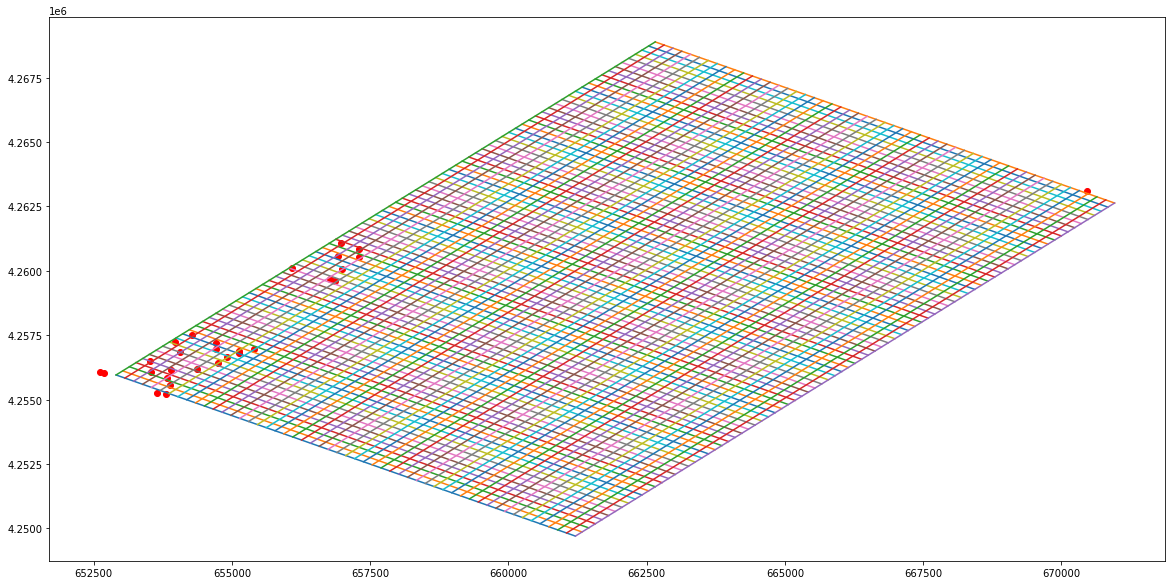

In [10]:
# Plot the basic model grid and sensors

plt.rcParams["figure.figsize"] = (20,10)
fig = plot_lines(mg.grid_lines)
plt.scatter(east, north, c='r')


In [23]:
# For raster intersect
import time
import shapely
import shapefile

try:
    import flopy
    from flopy.utils import Raster
except:
    fpth = os.path.abspath(os.path.join('..', '..'))
    sys.path.append(fpth)
    import flopy
    from flopy.utils import Raster

3.6.10 |Anaconda, Inc.| (default, Mar 23 2020, 17:58:33) [MSC v.1916 64 bit (AMD64)]
numpy version: 1.18.1
matplotlib version: 3.2.1
pandas version: 1.0.3
shapely version: 1.6.4.post2
flopy version: 3.3.0


### Raster files can be loaded using the `Raster.load` method

In [14]:
# 1 meter dem
raster_name = spath+"/model_dem.tif"

rio = Raster.load(raster_name)

In [26]:
# 10 meter dem
raster_name = spath+"/USGS_ten_meter_dem/USGS_13_n39w122_10meterdem.tif"

rio10 = Raster.load(raster_name)

In [129]:
# Convert 10 meter dem crs from lat long to utm zone 10n
import rasterio
from rasterio.warp import calculate_default_transform, reproject, Resampling

dst_crs = 'EPSG:32610'

with rasterio.open(raster_name) as src:
    transform, width, height = calculate_default_transform(
        src.crs, dst_crs, src.width, src.height, *src.bounds)
    kwargs = src.meta.copy()
    kwargs.update({
        'crs': dst_crs,
        'transform': transform,
        'width': width,
        'height': height
    })

    with rasterio.open(spath+'/USGS_ten_meter_dem/transformed.tif', 'w', **kwargs) as dst:
        for i in range(1, src.count + 1):
            reproject(
                source=rasterio.band(src, i),
                destination=rasterio.band(dst, i),
                src_transform=src.transform,
                src_crs=src.crs,
                dst_transform=transform,
                dst_crs=dst_crs,
                resampling=Resampling.nearest)

In [148]:
raster_name = spath+"/USGS_ten_meter_dem/transformed.tif"

rio10_utm = Raster.load(raster_name)

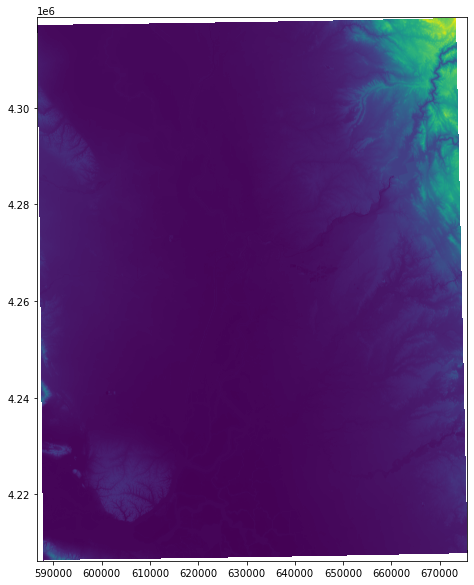

In [149]:
rio10_utm.plot()

In [151]:
rio10_utm

In [102]:
from flopy.utils.geometry import Polygon, LineString, Point
from flopy.export.shapefile_utils import recarray2shp, shp2recarray
from flopy.utils.modpathfile import PathlineFile, EndpointFile
from flopy.utils import geometry
from flopy.utils.reference import epsgRef

In [178]:
# Shapefile of model bounds
vertices = np.stack((ll,lr, ur, ul))


array([[ 661211.18      , 4249696.5       ],
       [ 661259.92701688, 4249761.18947631],
       [ 661218.39797035, 4249792.48385752],
       [ 661169.65095348, 4249727.7943812 ]])

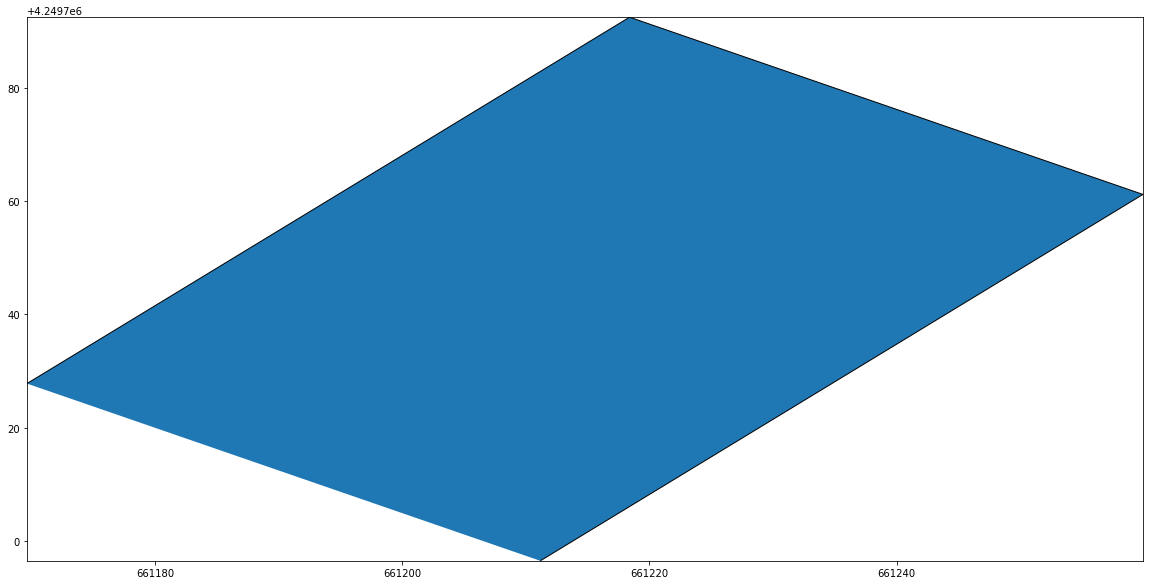

rec.array([(661211.18      , 4249696.5       ),
           (661259.92701688, 4249761.18947631),
           (661218.39797035, 4249792.48385752),
           (661169.65095348, 4249727.7943812 )],
          dtype=[('Easting', '<f8'), ('Northing', '<f8')])

In [111]:
geoms = Polygon(vertices)
geoms.plot() # this feature requires descartes
vertices_rec

In [160]:
vertices_rec = np.rec.array([ll, lr, ur, ul],
      dtype=[('Easting', '<f8'), ('Northing', '<f8')])
# Write shpfile
recarray2shp(vertices_rec, geoms, spath+ 'py_model_extent.shp', epsg=32610)

TypeError: object of type 'Polygon' has no len()

In [134]:

data = rio10_utm.sample_polygon(vertices, band=rio10_utm.bands[0])


In [135]:
mean = np.mean(data)
dmin = np.min(data)
dmax = np.max(data)
stdv = np.std(data)

s = "Minimum elevation: {:.2f}\nMaximum elevation: {:.2f}\nMean elevation: {:.2f}\nStandard deviation: {:.2f}"
print(s.format(dmin, dmax, mean, stdv))

Minimum elevation: 36.40
Maximum elevation: 39.92
Mean elevation: 37.63
Standard deviation: 0.94


In [159]:
# read in the shapefile
sf = shapefile.Reader(spath+ '/py_model_extent.shp')
shapes = sf.shapes()

ShapefileException: Unable to open C://Users/ajcalder/Box/Research_Calderwood/dem/py_model_extent.dbf or C://Users/ajcalder/Box/Research_Calderwood/dem/py_model_extent.shp.

In [180]:
print(vertices)
print(vertices[0])
print(vertices[1])
print(vertices[2])
print(vertices[3])

[[ 661211.18       4249696.5       ]
 [ 661259.92701688 4249761.18947631]
 [ 661218.39797035 4249792.48385752]
 [ 661169.65095348 4249727.7943812 ]]
[ 661211.18 4249696.5 ]
[ 661259.92701688 4249761.18947631]
[ 661218.39797035 4249792.48385752]
[ 661169.65095348 4249727.7943812 ]


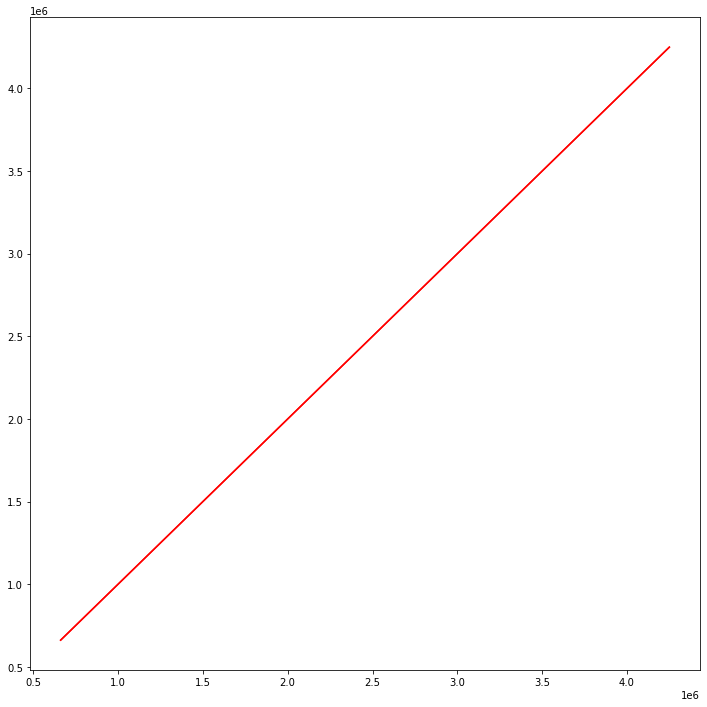

In [181]:
fig = plt.figure(figsize=(12, 12))
# ax = fig.add_subplot(1, 1, 1, aspect='equal')

# ax = rio10_utm.plot(ax=ax)
# plot the shapes for visualization
# for i in np.arange(0,len(vertices)-1):
# plt.plot(vertices[0], vertices[1], "r-")
plt.plot(vertices[1], vertices[2], "r-")
plt.plot(vertices[2], vertices[3], "r-")
# plt.colorbar(ax.images[0], shrink=0.7);

In [140]:
t0 = time.time()
cropped10_utm = rio10_utm.crop(vertices, invert=False)
crop_time = time.time() - t0


In [141]:
print(cropped10_utm)

None


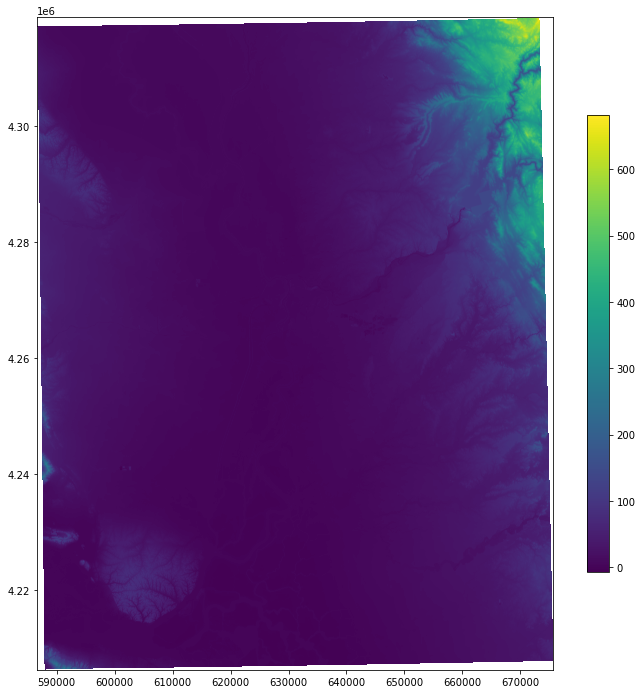

In [152]:
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(1, 1, 1, aspect='equal')

ax = rio10_utm.plot(ax=ax)
plt.colorbar(ax.images[0], shrink=0.7);

In [92]:
# Clipping 10 meter DEM for the model domain
from rasterio import mask
out_img, out_transform = mask(raster=rio10, shapes=geoms, crop=True)

TypeError: 'module' object is not callable

The bands within the raster can be viewed by calling the parameter `bands`; there is only one band in this raster

Using the built in .plot method, we can take a look at the DEM raster data before we start manipulating it

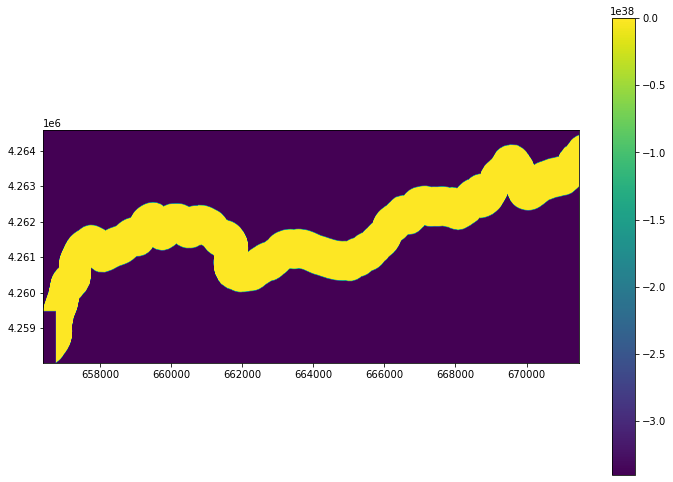

In [16]:
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(1, 1, 1, aspect='equal')

ax = rio.plot(ax=ax)
plt.colorbar(ax.images[0], shrink=0.7);